In [7]:
%matplotlib notebook

# LQR kontrola invertiranog njihala.
import math;
import matplotlib.pyplot as plt;
import numpy as np;
import numpy.linalg as nla;
import scipy.linalg as sla;
import control.matlab as con;
from matplotlib.animation import FuncAnimation;

con.use_numpy_matrix(flag=False, warn=True)

In [2]:
# Fizikalne veličine.
M = 0.5;
m = 0.2;
b = 0.1;
I = 0.006;
g = 9.8;
l = 0.3;

# Pomoćna konstanta.
DD = I*(M+m)+M*m*l*l;

In [3]:
# Definicija LTI sustava.
A = np.array( [
    [0, 1, 0, 0],
    [0, -b*(I+m*l*l)/DD, m*m*g*l*l/DD, 0],
    [0, 0, 0, 1],
    [0, -b*m*l/DD, (M+m)*m*g*l/DD, 0] ] );
B = np.array( [
    [0],
    [(I+m*l*l)/DD],
    [0],
    [m*l/DD] ] );
C = np.array( np.eye(4) );
D = np.array( [
    [0],
    [0],
    [0],
    [0] ] );

sys_G = con.ss( A, B, C, D );
print( sys_G );

<LinearIOSystem>: sys[2]
Inputs (1): ['u[0]']
Outputs (4): ['y[0]', 'y[1]', 'y[2]', 'y[3]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ 0.          1.          0.          0.        ]
     [ 0.         -0.18181818  2.67272727  0.        ]
     [ 0.          0.          0.          1.        ]
     [ 0.         -0.45454545 31.18181818  0.        ]]

B = [[0.        ]
     [1.81818182]
     [0.        ]
     [4.54545455]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]

D = [[0.]
     [0.]
     [0.]
     [0.]]



In [5]:
# Napravimo prvo stabilizaciju pomoću kontrolera K1 
# koji smješta polove sustava zatvorene petlje u (-1, -2, -3, -4).
K1 = con.place( A, B, [-1, -2, -3, -4 ] );
print( sla.eigvals( A - B*K1 ) );

# Napravimo spoj u feedback petlju K1 sa G.
K1_A = np.zeros( (0, 0) );
K1_B = np.zeros( (1, 0) );
K1_C = np.zeros( (0, 4) );
K1_D = K1;
sys_K1 = con.ss( K1_A, K1_B, K1_C, K1_D );

sys_GK1 = con.feedback( sys_G, sys_K1 );
print( con.pole( sys_GK1 ) );

[-4.+0.j -3.+0.j -2.+0.j -1.+0.j]
[-4.+0.j -3.+0.j -2.+0.j -1.+0.j]


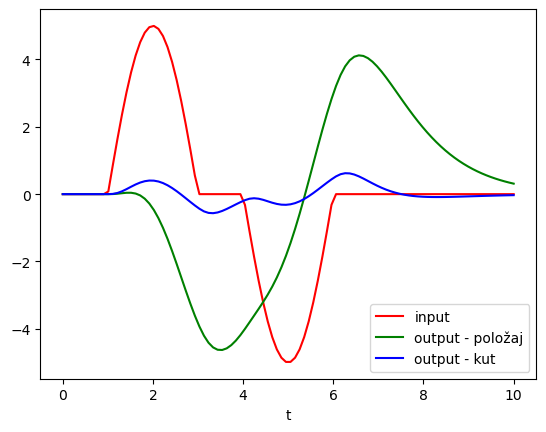

In [9]:
# Napravimo simulaciju sa sys_GK1, uz input koji simulira kao da je netko 
# malo gurnuo kolica u nekom smjeru.

# Vremenski interval i input;
t_max = 10; t_intervals = 100; dt = t_max / t_intervals;
t = np.linspace( 0, t_max, t_intervals );

# Input.
def uu( t ):
    if( t < 1 ):
        return 0;
    elif( t < 3 ):
        return 5*math.sin( (t-1)*math.pi/2 );
    elif( t < 4 ):
        return 0;
    elif( t < 6 ):
        return -5*math.sin( (t-4)*math.pi/2 );
    else:
        return 0;

u = list( map( uu, t ) );

# Početno stanje.
x0 = np.array( [[0], [0], [0], [0]] );

# Simulacija: yout = izlaz, tout = vremena, xout = stanja.
[yout1, tout1, xout1] = con.lsim( sys_GK1, u, t, x0 );

# Crtamo poziciju i kut.
# Crtamo input vs output.
%matplotlib inline

f = plt.figure;
plt.plot( t, u, 'r-', label='input' );
plt.plot( tout1, yout1[:, 0], 'g-', label='output - položaj' );
plt.plot( tout1, yout1[:, 2], 'b-', label='output - kut' );
plt.xlabel( 't' );
plt.legend();
plt.show();

In [10]:
# Sad ćemo napraviti LQR kontrolu.
# Sa ovakvim Q jako "obeshrabrujemo" velike x i theta.
Q = np.array( np.diag( [100, 1, 30, 1], 0 ) );
R = 1;

[K2, X, Lam] = con.lqr( sys_G, Q, R );

print( 'lqr je vratio svoj. vrijednosti: ', Lam );

# Spojimo kontroler K2 u sustav povratne sprege sa G.
# Napravimo spoj u feedback petlju K1 sa G.
K2_A = np.zeros( (0, 0) );
K2_B = np.zeros( (1, 0) );
K2_C = np.zeros( (0, 4) );
K2_D = K2;
sys_K2 = con.ss( K2_A, K2_B, K2_C, K2_D );

sys_GK2 = con.feedback( sys_G, sys_K2 );
print( 'Polovi u feedback petlji: ', con.pole( sys_GK2 ) );

lqr je vratio svoj. vrijednosti:  [-7.1337013+0.j       -5.518053 +0.j       -2.6295216+2.098063j
 -2.6295216-2.098063j]
Polovi u feedback petlji:  [-7.13370138+0.j         -5.5180531 +0.j         -2.62952154+2.09806293j
 -2.62952154-2.09806293j]


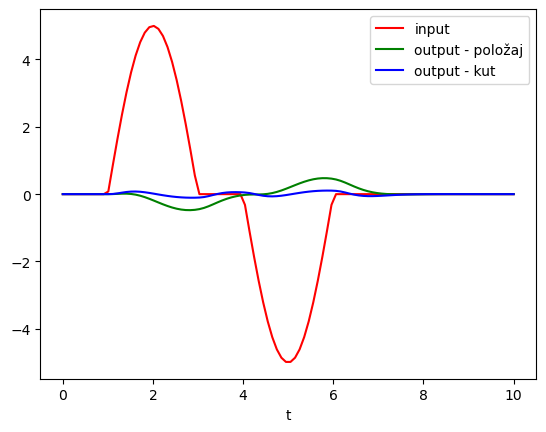

In [11]:
# Napravimo simulaciju sa sys_GK2, uz input koji simulira kao da je netko 
# malo gurnuo kolica u nekom smjeru.

# Simulacija: yout = izlaz, tout = vremena, xout = stanja.
[yout2, tout2, xout2] = con.lsim( sys_GK2, u, t, x0 );

# Crtamo poziciju i kut.
# Crtamo input vs output.
%matplotlib inline

f = plt.figure;
plt.plot( t, u, 'r-', label='input' );
plt.plot( tout2, yout2[:, 0], 'g-', label='output - položaj' );
plt.plot( tout2, yout2[:, 2], 'b-', label='output - kut' );
plt.xlabel( 't' );
plt.legend();
plt.show();

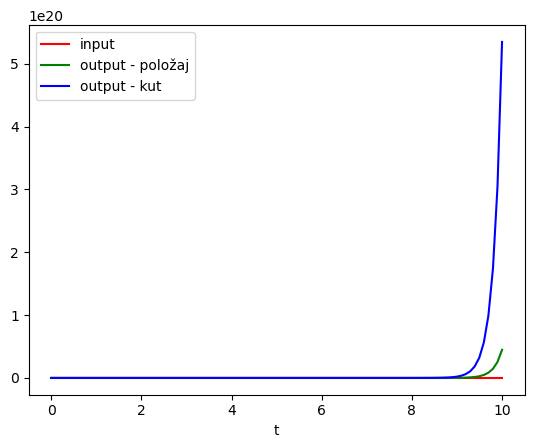

In [12]:
# Napravimo simulaciju nekontroliranog sustava sys_G, uz input koji simulira kao da je netko 
# malo gurnuo kolica u nekom smjeru.

# Simulacija: yout = izlaz, tout = vremena, xout = stanja.
[yout3, tout3, xout3] = con.lsim( sys_G, u, t, x0 );

# Crtamo poziciju i kut.
# Crtamo input vs output.
%matplotlib inline

f = plt.figure;
plt.plot( t, u, 'r-', label='input' );
plt.plot( tout3, yout3[:, 0], 'g-', label='output - položaj' );
plt.plot( tout3, yout3[:, 2], 'b-', label='output - kut' );
plt.xlabel( 't' );
plt.legend();
plt.show();

In [14]:
# Sljedeće tri linije omogućavaju crtanje animacija u Jupyter notebooku.
%matplotlib inline

from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript

# Napravimo i animacije za oba sustava, na istoj slici.
# Uoči da skala na x i na y osi nije ista i da se zapravo njihala "jače" ljuljaju no što se čini na slici.
# Napravimo sliku koja je široka "16", a visoka "2" da malo kompenziramo razliku skala.
fig = plt.figure( figsize=(16, 2) ); 
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-8, 8), ylim=(-l*1.1, l*1.1))
ax.grid()

# Svaki dio njihala će biti jedan plot unutar figure. 
# Uočite da je ova inicijalizacija prazna, tj. polja x koord. i y koord. su oba [] i zapravo se ništa ne crta.
pendulum1, = ax.plot([], [], 'b-', lw=2)           # "Štap" prvog njihala.
pendulum1_top, = ax.plot([], [], 'ko', lw=2)       # "Kugla" na vrhu prvog njihala.
pendulum1_base, = ax.plot([], [], 'b-', lw=2)      # "Kolica" prvog njihala.
pendulum1_vert, = ax.plot([], [], 'k--', lw=0.5)   # Os okomice prvog njihala.

pendulum2, = ax.plot([], [], 'g-', lw=2)           # "Štap" drugog njihala.
pendulum2_top, = ax.plot([], [], 'ko', lw=2)       # "Kugla" na vrhu drugog njihala.
pendulum2_base, = ax.plot([], [], 'g-', lw=2)      # "Kolica" drugog njihala.
pendulum2_vert, = ax.plot([], [], 'k--', lw=0.5)   # Os okomice drugog njihala.

pendulum3, = ax.plot([], [], 'm-', lw=2)           # "Štap" trećeg njihala.
pendulum3_top, = ax.plot([], [], 'ko', lw=2)       # "Kugla" na vrhu trećeg njihala.
pendulum3_base, = ax.plot([], [], 'm-', lw=2)      # "Kolica" trećeg njihala.
pendulum3_vert, = ax.plot([], [], 'k--', lw=0.5)   # Os okomice trećeg njihala.

input_vector, = ax.plot([], [], 'r-', lw=2)        # Ovdje ćemo crtati smjer sile koja djeluje na njihalo.

time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes) # Ispisivat ćemo vrijeme na koord. (0.05, 0.9).


def update(i):
    # Crtamo sliku u trenutku i.
    # Baza prvog njihala ("kolica").
    x1 = yout1[i, 0]; # Kolica se nalaze na koordinatama (x1, y1).
    y1 = 0;
    
    # "Kugla" njihala (tamo gdje je masa) je na koordinatama (x2, y2).
    x2 = x1 + l*math.sin(yout1[i, 2]);
    y2 = y1 + l*math.cos(yout1[i, 2]);
    
    # Sad nacrtamo prvo njihalo, tj. promijenimo x i y koordinate koje se prikazuju na odgovarajućem plotu.
    # Uočite da će biti nacrtan niz linija koji povezuje redom koordinate navedene u poljima.
    # Tj. plot.set_data([x1, x2, x3], [y1, y2, y3]) crta linije (x1, y1)--(x2, y2)--(x3, y3).
    pendulum1.set_data( [x1, x2], [y1, y2] );
    pendulum1_top.set_data( [x2], [y2] );
    pendulum1_base.set_data( [x1-0.2, x1-0.2, x1+0.2, x1+0.2, x1-0.2], [y1, y1-0.05, y1-0.05, y1, y1] );
    pendulum1_vert.set_data( [x1, x1], [y1, y1+0.3] );
    
    # Baza drugog njihala ("kolica").
    x1 = yout2[i, 0]; # Kolica se nalaze na koordinatama (x1, y1).
    y1 = 0;
    
    # "Kugla" njihala (tamo gdje je masa) je na koordinatama (x2, y2).
    x2 = x1 + l*math.sin(yout2[i, 2]);
    y2 = y1 + l*math.cos(yout2[i, 2]);
    
    # Sad nacrtamo drugo njihalo, na isti način kao prvo.
    pendulum2.set_data( [x1, x2], [y1, y2] );
    pendulum2_top.set_data( [x2], [y2] );
    pendulum2_base.set_data( [x1-0.2, x1-0.2, x1+0.2, x1+0.2, x1-0.2], [y1, y1-0.05, y1-0.05, y1, y1] );
    pendulum2_vert.set_data( [x1, x1], [y1, y1+0.3] );

    # Baza trećeg njihala ("kolica").
    x1 = yout3[i, 0]; # Kolica se nalaze na koordinatama (x1, y1).
    y1 = 0;
    
    # "Kugla" njihala (tamo gdje je masa) je na koordinatama (x2, y2).
    x2 = x1 + l*math.sin(yout3[i, 2]);
    y2 = y1 + l*math.cos(yout3[i, 2]);
    
    # Sad nacrtamo treće njihalo.
    pendulum3.set_data( [x1, x2], [y1, y2] );
    pendulum3_top.set_data( [x2], [y2] );
    pendulum3_base.set_data( [x1-0.2, x1-0.2, x1+0.2, x1+0.2, x1-0.2], [y1, y1-0.05, y1-0.05, y1, y1] );
    pendulum3_vert.set_data( [x1, x1], [y1, y1+0.3] );

    # Nacrtaj iznos sile u trenutku i kao vodoravnu liniju koja spaja točke 0 i u[i].
    input_vector.set_data( [0, u[i]], [-l, -l] );
    
    # Napiši trenutno vrijeme u gornji lijevi kut.
    time_text.set_text( time_template % (i*dt) );

# Generira "animaciju" na slici fig tako da za svaki od frameova i iz [0, 1, ..., t_intervals-1] pozove funkciju update(i)
ani = FuncAnimation(fig, update, frames=list( range( 0, t_intervals ) ) );

plt.close(); # Zatvori inicijalni prazni plot.
ani      # Prikaži animaciju